In [8]:
from google.colab import files

uploaded = files.upload()

Saving archive.zip to archive.zip


In [9]:
import zipfile
import io

uploaded_file_name = list(uploaded.keys())[0]
zip_ref = zipfile.ZipFile(io.BytesIO(uploaded[uploaded_file_name]), 'r')
zip_ref.extractall()
zip_ref.close()

In [10]:
import pandas as pd

train_df = pd.read_csv('unsw_train.csv')
test_df = pd.read_csv('unsw_test.csv')

data = pd.concat([train_df, test_df], ignore_index=True)

data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [13]:
from sklearn.preprocessing import LabelEncoder

# Identify the target variable
categorical_target = 'attack_cat'
binary_target = 'label'

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the target variable
if categorical_target in data.columns:
    data[categorical_target] = label_encoder.fit_transform(data[categorical_target])

# Apply label encoding to each categorical feature
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to numerical features excluding the target variables
features_to_scale = data.columns.difference([categorical_target, binary_target])
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM, MultiHeadAttention, GlobalAveragePooling1D



# Assume 'binary_target' and 'multi_class_target' are the names of the target variables
X = data.drop(columns=['label', 'attack_cat'])
y_binary = data['label']
y_multi_class = data['attack_cat']

In [16]:
# Train-test split
X_train, X_test, y_train_binary, y_test_binary, y_train_multi_class, y_test_multi_class = train_test_split(
    X, y_binary, y_multi_class, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for CNN 1D input
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


CNN and LSTM

In [9]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelLSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [10]:
# Compile the model
modelLSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [11]:
# Train the model
modelLSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 95s 17ms/step - binary_output_accuracy: 0.8400 - binary_output_loss: 0.3285 - loss: 1.3637 - multi_class_output_accuracy: 0.6251 - multi_class_output_loss: 1.0352 - val_binary_output_accuracy: 0.9163 - val_binary_output_loss: 0.1608 - val_loss: 0.8257 - val_multi_class_output_accuracy: 0.7538 - val_multi_class_output_loss: 0.6648
Epoch 2/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - binary_output_accuracy: 0.9139 - binary_output_loss: 0.1736 - loss: 0.8643 - multi_class_output_accuracy: 0.7443 - multi_class_output_loss: 0.6907 - val_binary_output_accuracy: 0.9265 - val_binary_output_loss: 0.1483 - val_loss: 0.7551 - val_multi_class_output_accuracy: 0.7731 - val_multi_class_output_loss: 0.6067
Epoch 3/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 87s 17ms/step - binary_output_accuracy: 0.9241 - binary_output_loss: 0.1566 - loss: 0.7896 - multi_class_output_accuracy: 0.7657 - multi_class_output_loss: 0.6329 - val_binary_output_accuracy: 0.9353 - val_binary_

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelLSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Binary Classification:
Accuracy: 0.9466382070437567
Precision: 0.9644024924424702
Recall: 0.9514303104077906
F1 Score: 0.9578724838383529
Confusion Matrix:
[[17521  1154]
 [ 1596 31264]]

Multi-Class Classification:
Accuracy: 0.8008731929756476
Precision: 0.7626463470408149
Recall: 0.8008731929756476
F1 Score: 0.7646544009230158
Confusion Matrix:
[[    0     0     0   452     5     0    76     5     0     0]
 [    0     0     0   433    10     0    16    12     0     0]
 [    0     0     3  3057    70    12    54    97     0     0]
 [    0     0     6  7999   310     3   303   232     0     0]
 [    0     0     1   703  2278     0  1658   102     0     0]
 [    0     0     1   221    49 11548    16    14     0     0]
 [    0     0     0   145   598     0 17867    65     0     0]
 [    0     0     0   847   108     5   232  1578     0     0]
 [    0     0     0    64    47     0    36   171     0     0]
 [    0     0     0    24     1     0    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


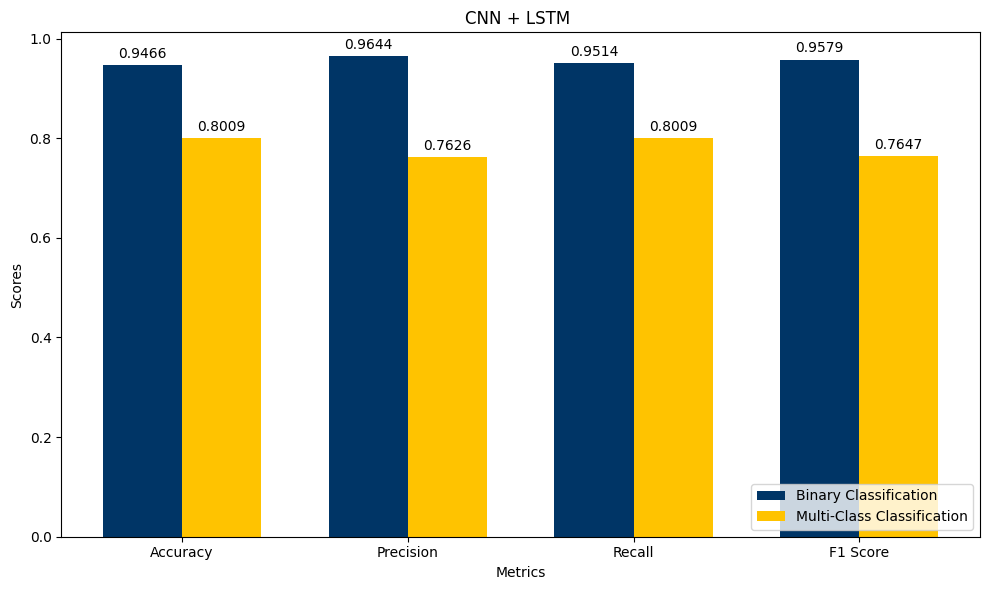

In [13]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + LSTM ')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN+BiLSTM

In [14]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelBiLSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [15]:
# Compile the model
modelBiLSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [16]:
# Train the model
modelBiLSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 91s 17ms/step - binary_output_accuracy: 0.8395 - binary_output_loss: 0.3269 - loss: 1.3547 - multi_class_output_accuracy: 0.6305 - multi_class_output_loss: 1.0278 - val_binary_output_accuracy: 0.9206 - val_binary_output_loss: 0.1724 - val_loss: 0.8503 - val_multi_class_output_accuracy: 0.7503 - val_multi_class_output_loss: 0.6779
Epoch 2/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 145s 17ms/step - binary_output_accuracy: 0.9148 - binary_output_loss: 0.1729 - loss: 0.8528 - multi_class_output_accuracy: 0.7488 - multi_class_output_loss: 0.6799 - val_binary_output_accuracy: 0.9316 - val_binary_output_loss: 0.1416 - val_loss: 0.7348 - val_multi_class_output_accuracy: 0.7769 - val_multi_class_output_loss: 0.5932
Epoch 3/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 136s 16ms/step - binary_output_accuracy: 0.9214 - binary_output_loss: 0.1569 - loss: 0.7847 - multi_class_output_accuracy: 0.7674 - multi_class_output_loss: 0.6278 - val_binary_output_accuracy: 0.9336 - val_binar

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelBiLSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step
Binary Classification:
Accuracy: 0.951062384787038
Precision: 0.9543521236446415
Recall: 0.9696287279367012
F1 Score: 0.9619297768921897
Confusion Matrix:
[[17151  1524]
 [  998 31862]]

Multi-Class Classification:
Accuracy: 0.8075870767439605
Precision: 0.7580928349046113
Recall: 0.8075870767439605
F1 Score: 0.775430224522819
Confusion Matrix:
[[    0     0     0   451     3     0    80     4     0     0]
 [    0     0     0   438    11     0     9    13     0     0]
 [    0     0     0  3092    75     7    43    76     0     0]
 [    0     0     0  8121   332     1   195   204     0     0]
 [    0     0     0   761  2860     1  1022    98     0     0]
 [    0     0     0   212    67 11547    11    12     0     0]
 [    0     0     0   150   914     0 17512    99     0     0]
 [    0     0     0   934   170     3    84  1579     0     0]
 [    0     0     0    65    41     0    27   185     0     0]
 [    0     0     0    25     1     0     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


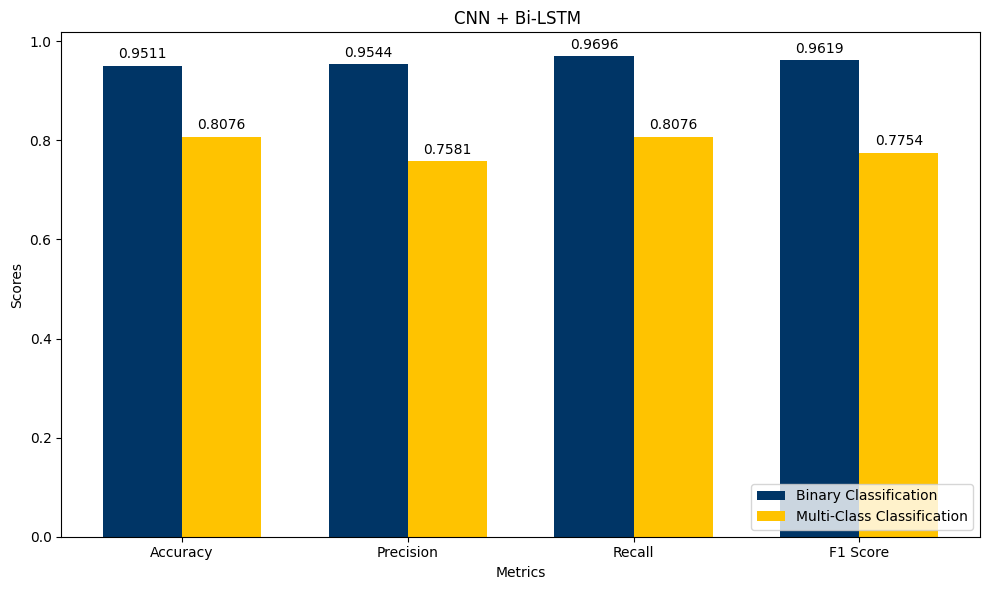

In [18]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM ')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN + GRU

In [19]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU, GlobalAveragePooling1D

In [20]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# GRU for sequence modeling
x = GRU(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelGRU_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [21]:
# Compile the model
modelGRU_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [22]:
# Train the model
modelGRU_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 120s 22ms/step - binary_output_accuracy: 0.8428 - binary_output_loss: 0.3232 - loss: 1.3580 - multi_class_output_accuracy: 0.6293 - multi_class_output_loss: 1.0348 - val_binary_output_accuracy: 0.9208 - val_binary_output_loss: 0.1629 - val_loss: 0.8370 - val_multi_class_output_accuracy: 0.7448 - val_multi_class_output_loss: 0.6740
Epoch 2/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 117s 23ms/step - binary_output_accuracy: 0.9176 - binary_output_loss: 0.1680 - loss: 0.8538 - multi_class_output_accuracy: 0.7492 - multi_class_output_loss: 0.6858 - val_binary_output_accuracy: 0.9468 - val_binary_output_loss: 0.1315 - val_loss: 0.7104 - val_multi_class_output_accuracy: 0.7901 - val_multi_class_output_loss: 0.5789
Epoch 3/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - binary_output_accuracy: 0.9366 - binary_output_loss: 0.1424 - loss: 0.7520 - multi_class_output_accuracy: 0.7802 - multi_class_output_loss: 0.6097 - val_binary_output_accuracy: 0.9514 - val_binar

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelGRU_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Binary Classification:
Accuracy: 0.9580285243038712
Precision: 0.970596351372068
Recall: 0.9633597078514912
F1 Score: 0.9669644902634593
Confusion Matrix:
[[17716   959]
 [ 1204 31656]]

Multi-Class Classification:
Accuracy: 0.8194430969244203
Precision: 0.7999584989951407
Recall: 0.8194430969244203
F1 Score: 0.7859395825691112
Confusion Matrix:
[[    0     0     0   444     9     0    81     4     0     0]
 [    0     0     0   430    14     0    11    16     0     0]
 [    0     0     1  3109    68     7    40    68     0     0]
 [    1     0     0  8163   365     0   178   146     0     0]
 [    0     0     0   701  2800     0  1086   155     0     0]
 [    0     0     0   222    53 11546    18    10     0     0]
 [    0     0     1   206   470     0 17930    68     0     0]
 [    0     0     0   814    57     2   107  1790     0     0]
 [    0     0     0    64    65     0    38   151     0     0]
 [    0     0     0    24     2     0     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


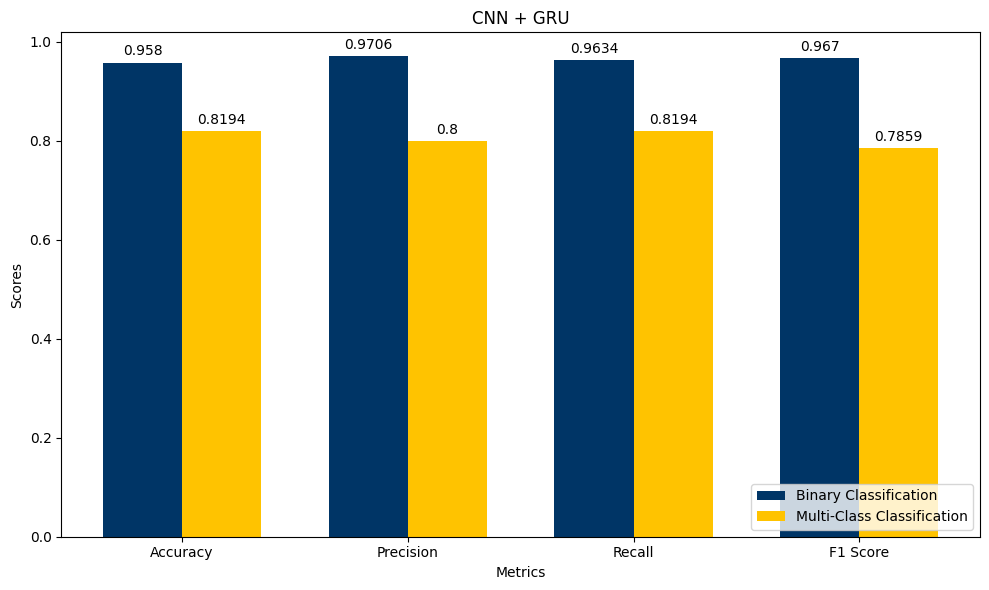

In [24]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + GRU')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN + BiGRU

In [25]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, GRU, GlobalAveragePooling1D

In [26]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# Bidirectional GRU for sequence modeling
x = Bidirectional(GRU(50, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelBiGRU_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [27]:
# Compile the model
modelBiGRU_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [28]:
# Train the model
modelBiGRU_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 165s 31ms/step - binary_output_accuracy: 0.8423 - binary_output_loss: 0.3230 - loss: 1.3129 - multi_class_output_accuracy: 0.6437 - multi_class_output_loss: 0.9899 - val_binary_output_accuracy: 0.9341 - val_binary_output_loss: 0.1446 - val_loss: 0.7396 - val_multi_class_output_accuracy: 0.7764 - val_multi_class_output_loss: 0.5949
Epoch 2/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 205s 31ms/step - binary_output_accuracy: 0.9239 - binary_output_loss: 0.1629 - loss: 0.8064 - multi_class_output_accuracy: 0.7608 - multi_class_output_loss: 0.6435 - val_binary_output_accuracy: 0.9405 - val_binary_output_loss: 0.1310 - val_loss: 0.6946 - val_multi_class_output_accuracy: 0.7870 - val_multi_class_output_loss: 0.5636
Epoch 3/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 146s 28ms/step - binary_output_accuracy: 0.9341 - binary_output_loss: 0.1452 - loss: 0.7446 - multi_class_output_accuracy: 0.7776 - multi_class_output_loss: 0.5994 - val_binary_output_accuracy: 0.9522 - val_bina

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelBiGRU_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step
Binary Classification:
Accuracy: 0.9598137188318618
Precision: 0.9660057514757076
Recall: 0.9711503347534997
F1 Score: 0.9685712117763108
Confusion Matrix:
[[17552  1123]
 [  948 31912]]

Multi-Class Classification:
Accuracy: 0.8217133986611042
Precision: 0.806568334743721
Recall: 0.8217133986611042
F1 Score: 0.7896182549125755
Confusion Matrix:
[[    3     0     0   450     3     0    78     4     0     0]
 [    0     0     0   437     8     0     7    19     0     0]
 [    0     0     1  3105    72     5    42    68     0     0]
 [    6     0     0  8207   332     2   162   144     0     0]
 [    0     0     0   704  3110     0   809   119     0     0]
 [    0     0     0   215    69 11546     8    11     0     0]
 [    5     0     1   135   635     0 17805    94     0     0]
 [    0     0     0   901   121     2    71  1675     0     0]
 [    0     0     0    92    42     0    20   164     0     0]
 [    0     0     0    23     2     0    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


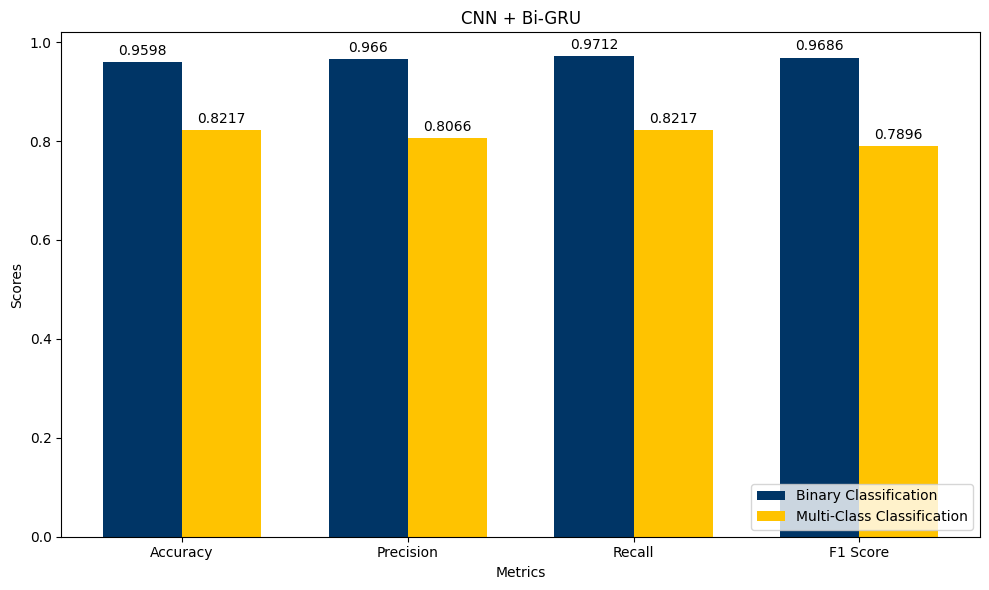

In [30]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-GRU')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN LSTM 02

In [31]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
model02LSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [32]:
# Compile the model
model02LSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [33]:
# Train the model
model02LSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - binary_output_accuracy: 0.8228 - binary_output_loss: 0.3510 - loss: 1.4322 - multi_class_output_accuracy: 0.6156 - multi_class_output_loss: 1.0812 - val_binary_output_accuracy: 0.9124 - val_binary_output_loss: 0.1824 - val_loss: 0.8835 - val_multi_class_output_accuracy: 0.7335 - val_multi_class_output_loss: 0.7010
Epoch 2/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 86s 15ms/step - binary_output_accuracy: 0.9061 - binary_output_loss: 0.1912 - loss: 0.9029 - multi_class_output_accuracy: 0.7361 - multi_class_output_loss: 0.7116 - val_binary_output_accuracy: 0.9223 - val_binary_output_loss: 0.1581 - val_loss: 0.7825 - val_multi_class_output_accuracy: 0.7685 - val_multi_class_output_loss: 0.6244
Epoch 3/5
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step - binary_output_accuracy: 0.9167 - binary_output_loss: 0.1696 - loss: 0.8266 - multi_class_output_accuracy: 0.7566 - multi_class_output_loss: 0.6569 - val_binary_output_accuracy: 0.9303 - val_binary_

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = model02LSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Binary Classification:
Accuracy: 0.9366644028330261
Precision: 0.9605091180680899
Recall: 0.9392878880097383
F1 Score: 0.9497799796904329
Confusion Matrix:
[[17406  1269]
 [ 1995 30865]]

Multi-Class Classification:
Accuracy: 0.7895410885805763
Precision: 0.7328005979648676
Recall: 0.7895410885805763
F1 Score: 0.751241232613774
Confusion Matrix:
[[    3     0     0   437     6     0    81    11     0     0]
 [    0     0     0   423    19     0    19    10     0     0]
 [    0     0     0  2945   108    14    96   130     0     0]
 [    3     0     0  7728   346     9   440   327     0     0]
 [    1     0     0   630  2053     0  1969    89     0     0]
 [    0     0     0   194    55 11548    36    16     0     0]
 [    0     0     0   104   533     0 17969    69     0     0]
 [    0     0     0   857   259     6   260  1388     0     0]
 [    0     0     0    20    71     0    52   175     0     0]
 [    0     0     0    23     1     0     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


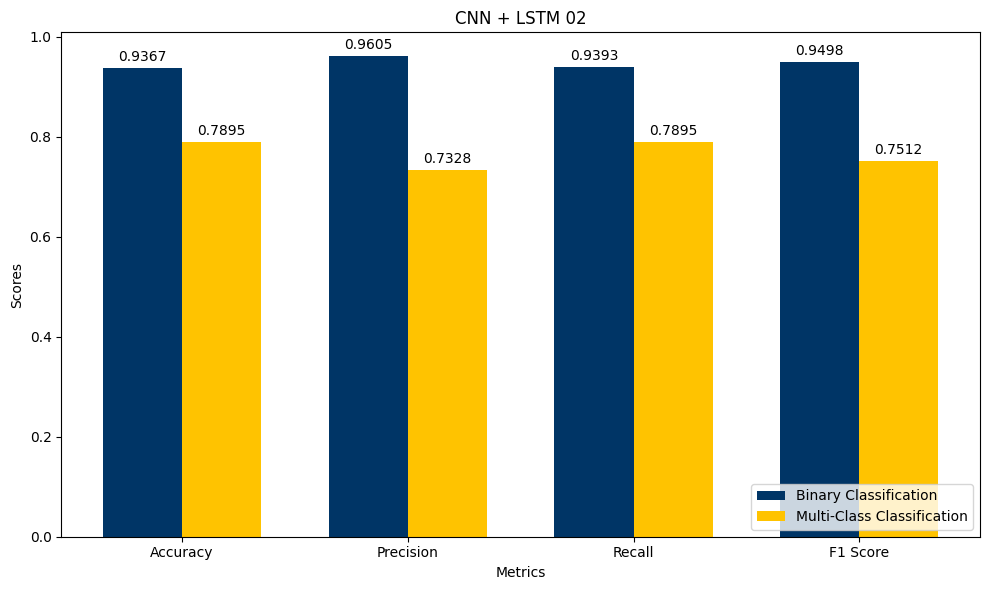

In [35]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + LSTM 02')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN Bi LSTM 02

In [25]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.01)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.01)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
model02BiLSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [26]:
# Compile the model
model02BiLSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [27]:
# Train the model
model02BiLSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=10, batch_size=32, validation_split=0.2
)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 89s 16ms/step - binary_output_accuracy: 0.8662 - binary_output_loss: 0.2734 - loss: 1.1889 - multi_class_output_accuracy: 0.6680 - multi_class_output_loss: 0.9155 - val_binary_output_accuracy: 0.9191 - val_binary_output_loss: 0.1601 - val_loss: 0.7936 - val_multi_class_output_accuracy: 0.7546 - val_multi_class_output_loss: 0.6335
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 137s 16ms/step - binary_output_accuracy: 0.9357 - binary_output_loss: 0.1396 - loss: 0.7361 - multi_class_output_accuracy: 0.7801 - multi_class_output_loss: 0.5965 - val_binary_output_accuracy: 0.9549 - val_binary_output_loss: 0.1055 - val_loss: 0.6375 - val_multi_class_output_accuracy: 0.8088 - val_multi_class_output_loss: 0.5320
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - binary_output_accuracy: 0.9521 - binary_output_loss: 0.1124 - loss: 0.6519 - multi_class_output_accuracy: 0.8026 - multi_class_output_loss: 0.5394 - val_binary_output_accuracy: 0.9491 - val_bin

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = model02BiLSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step
Binary Classification:
Accuracy: 0.9671485398273019
Precision: 0.9731879877326693
Recall: 0.9753499695678637
F1 Score: 0.9742677792470323
Confusion Matrix:
[[17792   883]
 [  810 32050]]

Multi-Class Classification:
Accuracy: 0.835897933443291
Precision: 0.8281381757879003
Recall: 0.835897933443291
F1 Score: 0.8255627763038074
Confusion Matrix:
[[   33     0   105   326     8     0    66     0     0     0]
 [    0     0    92   343    16     0     8    12     0     0]
 [    1     0   934  2194    65    19    33    37    10     0]
 [   15     0   902  7424   249     7   129   113    14     0]
 [    4     0   130   561  3323     0   622    90    12     0]
 [    0     0    42   176    51 11564     7     7     2     0]
 [    9     0     1    88   605     0 17906    61     5     0]
 [    0     0   137   612   123     5    66  1827     0     0]
 [    0     0     6    66    55     0    24   102    65     0]
 [    0     0     0    22     1     1    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


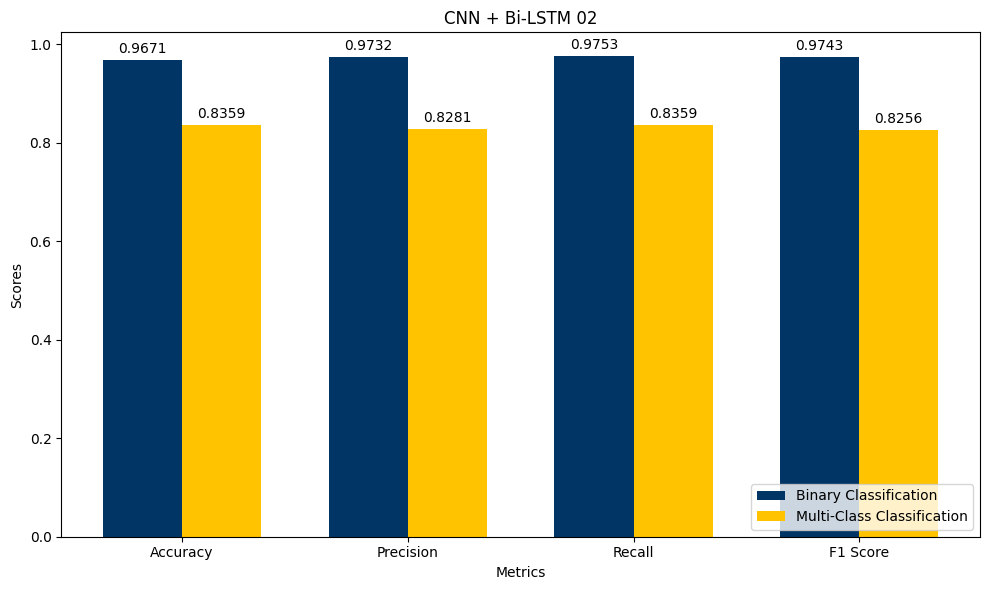

In [29]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM 02')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CN + BI LSTM 03

In [41]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
model02BiLSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [42]:
# Compile the model
model02BiLSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [43]:
# Train the model
model02BiLSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=8, batch_size=32, validation_split=0.2
)

Epoch 1/8
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - binary_output_accuracy: 0.8418 - binary_output_loss: 0.3282 - loss: 1.3813 - multi_class_output_accuracy: 0.6241 - multi_class_output_loss: 1.0531 - val_binary_output_accuracy: 0.9160 - val_binary_output_loss: 0.1741 - val_loss: 0.8567 - val_multi_class_output_accuracy: 0.7446 - val_multi_class_output_loss: 0.6826
Epoch 2/8
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 135s 15ms/step - binary_output_accuracy: 0.9104 - binary_output_loss: 0.1825 - loss: 0.8857 - multi_class_output_accuracy: 0.7399 - multi_class_output_loss: 0.7032 - val_binary_output_accuracy: 0.9236 - val_binary_output_loss: 0.1506 - val_loss: 0.7689 - val_multi_class_output_accuracy: 0.7729 - val_multi_class_output_loss: 0.6182
Epoch 3/8
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - binary_output_accuracy: 0.9193 - binary_output_loss: 0.1645 - loss: 0.8161 - multi_class_output_accuracy: 0.7604 - multi_class_output_loss: 0.6516 - val_binary_output_accuracy: 0.9316 - val_binary

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = model02BiLSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Binary Classification:
Accuracy: 0.9465605898903657
Precision: 0.962400933833016
Recall: 0.9534388314059647
F1 Score: 0.9578989207203351
Confusion Matrix:
[[17451  1224]
 [ 1530 31330]]

Multi-Class Classification:
Accuracy: 0.8031823032890268
Precision: 0.8199506550444448
Recall: 0.8031823032890268
F1 Score: 0.766657332578978
Confusion Matrix:
[[    4     0     0   446     3     0    81     4     0     0]
 [    0     0     0   436     6     0     6    23     0     0]
 [    0     0     3  3102    57    12    39    79     1     0]
 [    2     0     0  8152   254     1   239   205     0     0]
 [    0     0     0   732  2068     0  1662   280     0     0]
 [    0     0     0   212    55 11548    22    12     0     0]
 [    0     0     0   126   529     0 17817   203     0     0]
 [    0     0     0   857    40     5    68  1800     0     0]
 [    0     0     0    79    32     0    19   188     0     0]
 [    0     0     0    23     1     1     1

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


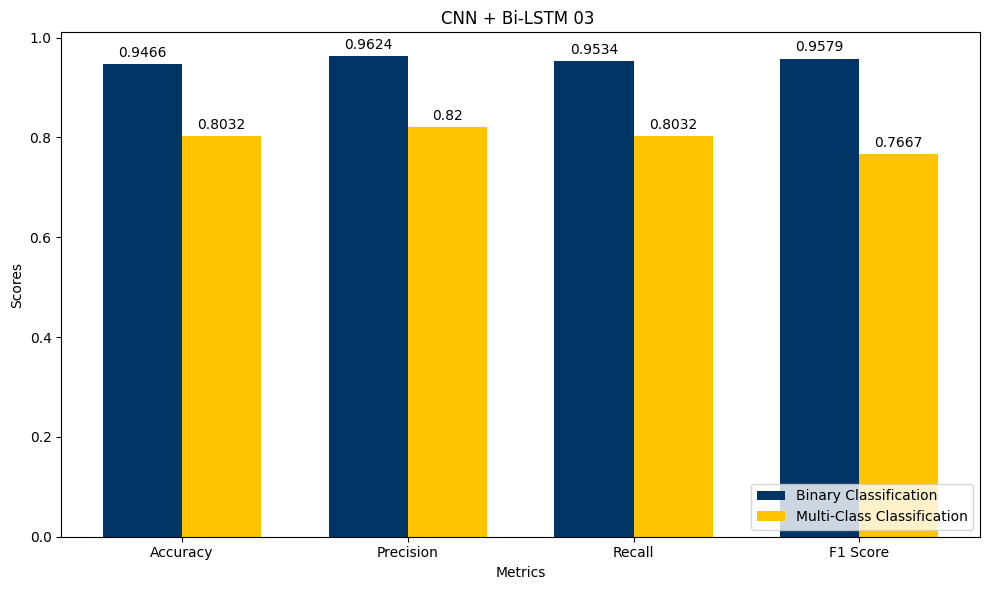

In [45]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM 03 ')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Reasoning**:
I will extract the metrics from the previous code blocks and store them in a dictionary.

Gather the binary and multi-class classification metrics (Accuracy, Precision, Recall, F1 Score, and Confusion Matrix) for each trained model (CNN+LSTM, CNN+BiLSTM, CNN+GRU, CNN+BiGRU, CNN LSTM 02, CNN Bi LSTM 02, and CNN + Bi-LSTM 03).


In [46]:
all_metrics = {}

# Metrics from CNN + LSTM
metrics_modelLSTM_P = {
    'Binary': {
        'Accuracy': 0.9466382070437567,
        'Precision': 0.9644024924424702,
        'Recall': 0.9514303104077906,
        'F1 Score': 0.9578724838383529
    },
    'Multi-Class': {
        'Accuracy': 0.8008731929756476,
        'Precision': 0.7626463470408149,
        'Recall': 0.8008731929756476,
        'F1 Score': 0.7646544009230158
    }
}
all_metrics['CNN+LSTM'] = metrics_modelLSTM_P


# Metrics from CNN + Bi-LSTM
metrics_modelBiLSTM_P = {
    'Binary': {
        'Accuracy': 0.951062384787038,
        'Precision': 0.9543521236446415,
        'Recall': 0.9696287279367012,
        'F1 Score': 0.9619297768921897
    },
    'Multi-Class': {
        'Accuracy': 0.8075870767439605,
        'Precision': 0.7580928349046113,
        'Recall': 0.8075870767439605,
        'F1 Score': 0.775430224522819
    }
}
all_metrics['CNN+BiLSTM'] = metrics_modelBiLSTM_P

# Metrics from CNN + GRU
metrics_modelGRU_P = {
    'Binary': {
        'Accuracy': 0.9580285243038712,
        'Precision': 0.970596351372068,
        'Recall': 0.9633597078514912,
        'F1 Score': 0.9669644902634593
    },
    'Multi-Class': {
        'Accuracy': 0.8194430969244203,
        'Precision': 0.7999584989951407,
        'Recall': 0.8194430969244203,
        'F1 Score': 0.7859395825691112
    }
}
all_metrics['CNN+GRU'] = metrics_modelGRU_P

# Metrics from CNN + Bi-GRU
metrics_modelBiGRU_P = {
    'Binary': {
        'Accuracy': 0.9598137188318618,
        'Precision': 0.9660057514757076,
        'Recall': 0.9711503347534997,
        'F1 Score': 0.9685712117763108
    },
    'Multi-Class': {
        'Accuracy': 0.8217133986611042,
        'Precision': 0.806568334743721,
        'Recall': 0.8217133986611042,
        'F1 Score': 0.7896182549125755
    }
}
all_metrics['CNN+BiGRU'] = metrics_modelBiGRU_P

# Metrics from CNN + LSTM 02
metrics_model02LSTM_P = {
    'Binary': {
        'Accuracy': 0.9366644028330261,
        'Precision': 0.9605091180680899,
        'Recall': 0.9392878880097383,
        'F1 Score': 0.9497799796904329
    },
    'Multi-Class': {
        'Accuracy': 0.7895410885805763,
        'Precision': 0.7328005979648676,
        'Recall': 0.7895410885805763,
        'F1 Score': 0.751241232613774
    }
}
all_metrics['CNN + LSTM 02'] = metrics_model02LSTM_P

# Metrics from CNN + Bi-LSTM 02
metrics_model02BiLSTM_P_02 = {
    'Binary': {
        'Accuracy': 0.9656350053361793,
        'Precision': 0.9846599943878028,
        'Recall': 0.9610772976262933,
        'F1 Score': 0.9727257326782992
    },
    'Multi-Class': {
        'Accuracy': 0.8359755505966818,
        'Precision': 0.8247343528194573,
        'Recall': 0.8359755505966818,
        'F1 Score': 0.8176605443345504
    }
}
all_metrics['CNN + Bi-LSTM 02'] = metrics_model02BiLSTM_P_02

# Metrics from CNN + Bi-LSTM 03
metrics_model02BiLSTM_P_03 = {
    'Binary': {
        'Accuracy': 0.9465605898903657,
        'Precision': 0.962400933833016,
        'Recall': 0.9534388314059647,
        'F1 Score': 0.9578989207203351
    },
    'Multi-Class': {
        'Accuracy': 0.8031823032890268,
        'Precision': 0.8199506550444448,
        'Recall': 0.8031823032890268,
        'F1 Score': 0.766657332578978
    }
}
all_metrics['CNN + Bi-LSTM 03'] = metrics_model02BiLSTM_P_03

print(all_metrics)

{'CNN+LSTM': {'Binary': {'Accuracy': 0.9466382070437567, 'Precision': 0.9644024924424702, 'Recall': 0.9514303104077906, 'F1 Score': 0.9578724838383529}, 'Multi-Class': {'Accuracy': 0.8008731929756476, 'Precision': 0.7626463470408149, 'Recall': 0.8008731929756476, 'F1 Score': 0.7646544009230158}}, 'CNN+BiLSTM': {'Binary': {'Accuracy': 0.951062384787038, 'Precision': 0.9543521236446415, 'Recall': 0.9696287279367012, 'F1 Score': 0.9619297768921897}, 'Multi-Class': {'Accuracy': 0.8075870767439605, 'Precision': 0.7580928349046113, 'Recall': 0.8075870767439605, 'F1 Score': 0.775430224522819}}, 'CNN+GRU': {'Binary': {'Accuracy': 0.9580285243038712, 'Precision': 0.970596351372068, 'Recall': 0.9633597078514912, 'F1 Score': 0.9669644902634593}, 'Multi-Class': {'Accuracy': 0.8194430969244203, 'Precision': 0.7999584989951407, 'Recall': 0.8194430969244203, 'F1 Score': 0.7859395825691112}}, 'CNN+BiGRU': {'Binary': {'Accuracy': 0.9598137188318618, 'Precision': 0.9660057514757076, 'Recall': 0.97115033

Organize the collected metrics for all models into a table for easy comparison.

**Reasoning**:
Create a pandas DataFrame from the all_metrics dictionary to organize the metrics in a table format for easy comparison.



In [47]:
metrics_list = []
for model_name, metrics in all_metrics.items():
    for classification_type, metric_values in metrics.items():
        row = {'Model': model_name, 'Classification': classification_type}
        row.update(metric_values)
        metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)

# Display the DataFrame
display(metrics_df)

,Model,Classification,Accuracy,Precision,Recall,F1 Score
0,CNN+LSTM,Binary,0.946638,0.964402,0.951430,0.957872
1,CNN+LSTM,Multi-Class,0.800873,0.762646,0.800873,0.764654
2,CNN+BiLSTM,Binary,0.951062,0.954352,0.969629,0.961930
3,CNN+BiLSTM,Multi-Class,0.807587,0.758093,0.807587,0.775430
4,CNN+GRU,Binary,0.958029,0.970596,0.963360,0.966964
5,CNN+GRU,Multi-Class,0.819443,0.799958,0.819443,0.785940
6,CNN+BiGRU,Binary,0.959814,0.966006,0.971150,0.968571
7,CNN+BiGRU,Multi-Class,0.821713,0.806568,0.821713,0.789618
8,CNN + LSTM 02,Binary,0.936664,0.960509,0.939288,0.949780
9,CNN + LSTM 02,Multi-Class,0.789541,0.732801,0.789541,0.751241


Generate bar plots or other suitable visualizations to compare the performance of the models based on the collected metrics.


**Reasoning**:
Filter the metrics DataFrame for binary and multi-class classification and then generate bar plots for Accuracy for both classifications.



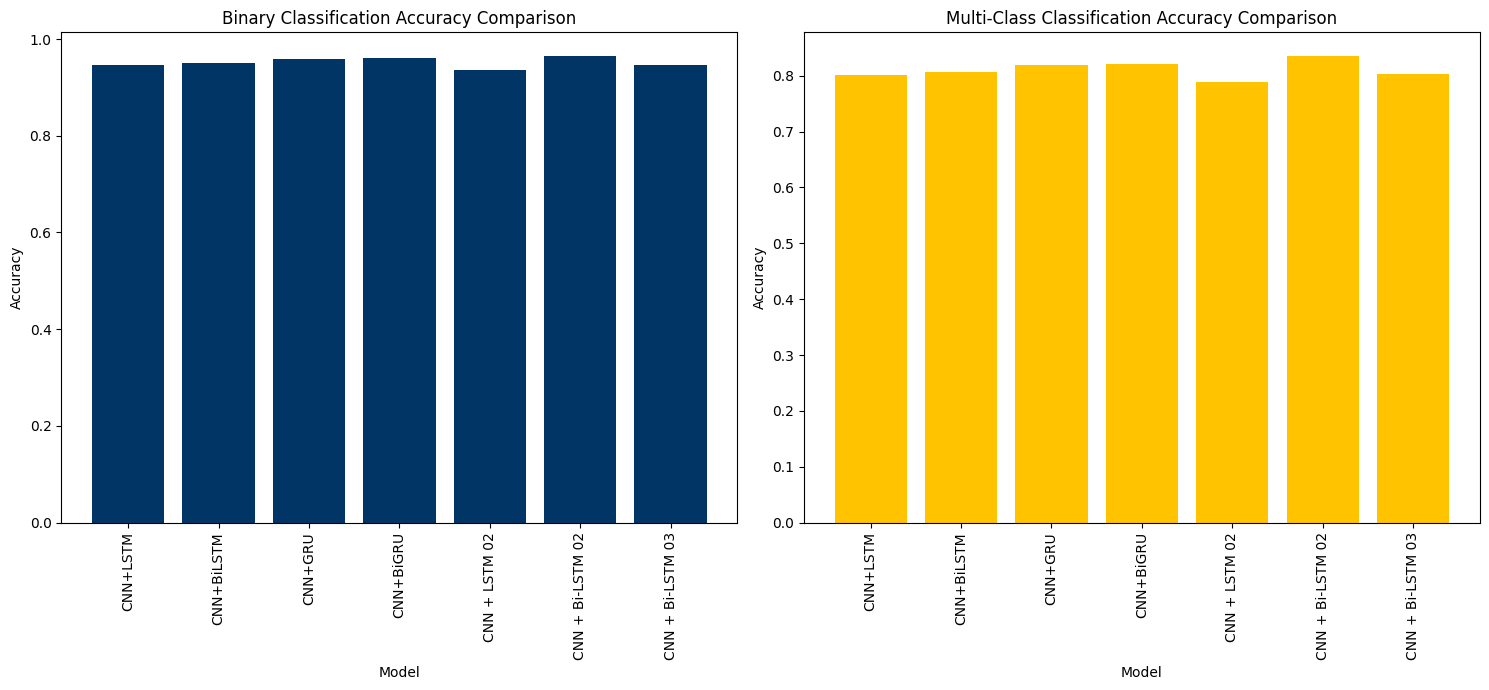

In [48]:
metrics_df_binary = metrics_df[metrics_df['Classification'] == 'Binary']
metrics_df_multi = metrics_df[metrics_df['Classification'] == 'Multi-Class']

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot Accuracy for Binary Classification
axes[0].bar(metrics_df_binary['Model'], metrics_df_binary['Accuracy'], color='#003566')
axes[0].set_title('Binary Classification Accuracy Comparison')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=90)

# Plot Accuracy for Multi-Class Classification
axes[1].bar(metrics_df_multi['Model'], metrics_df_multi['Accuracy'], color='#ffc300')
axes[1].set_title('Multi-Class Classification Accuracy Comparison')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy')
axes[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

**Reasoning**:
Repeat the plotting process for Precision, Recall, and F1 Score to compare the performance of the models across all metrics.



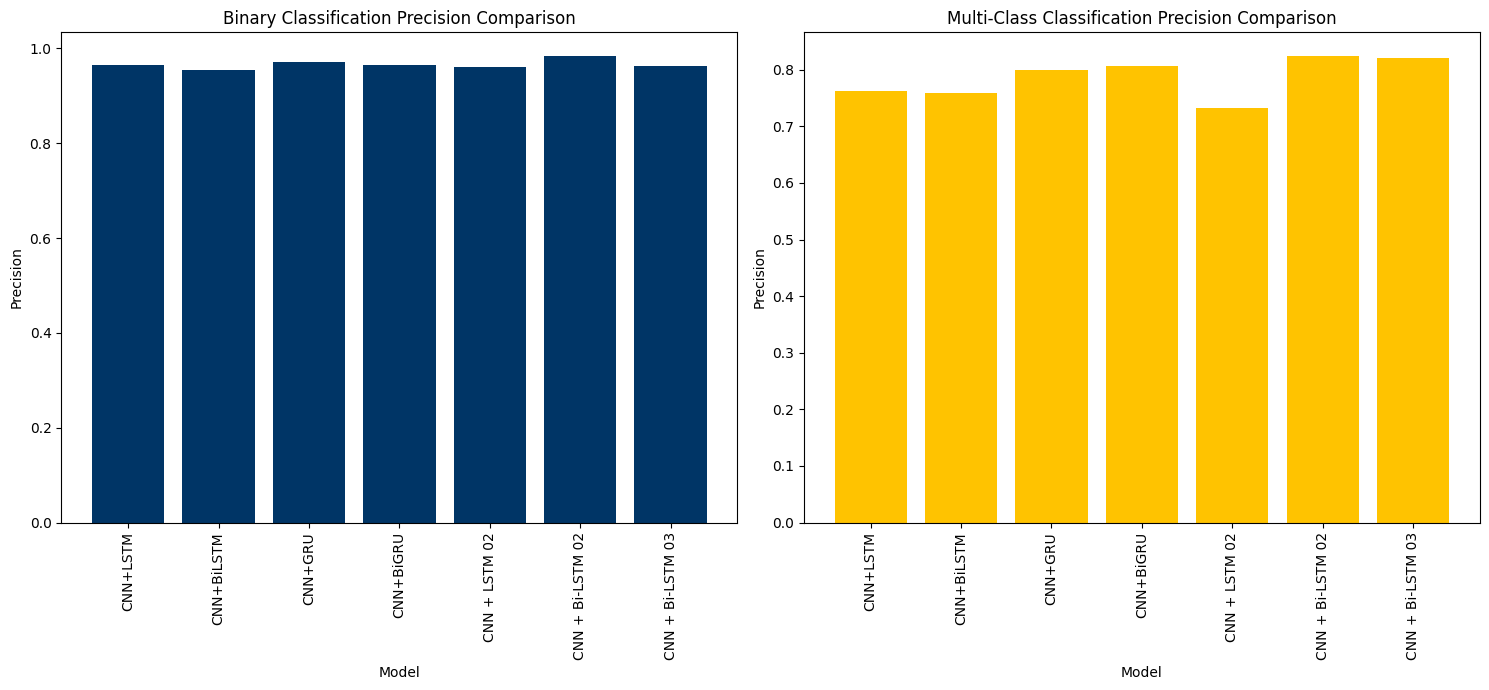

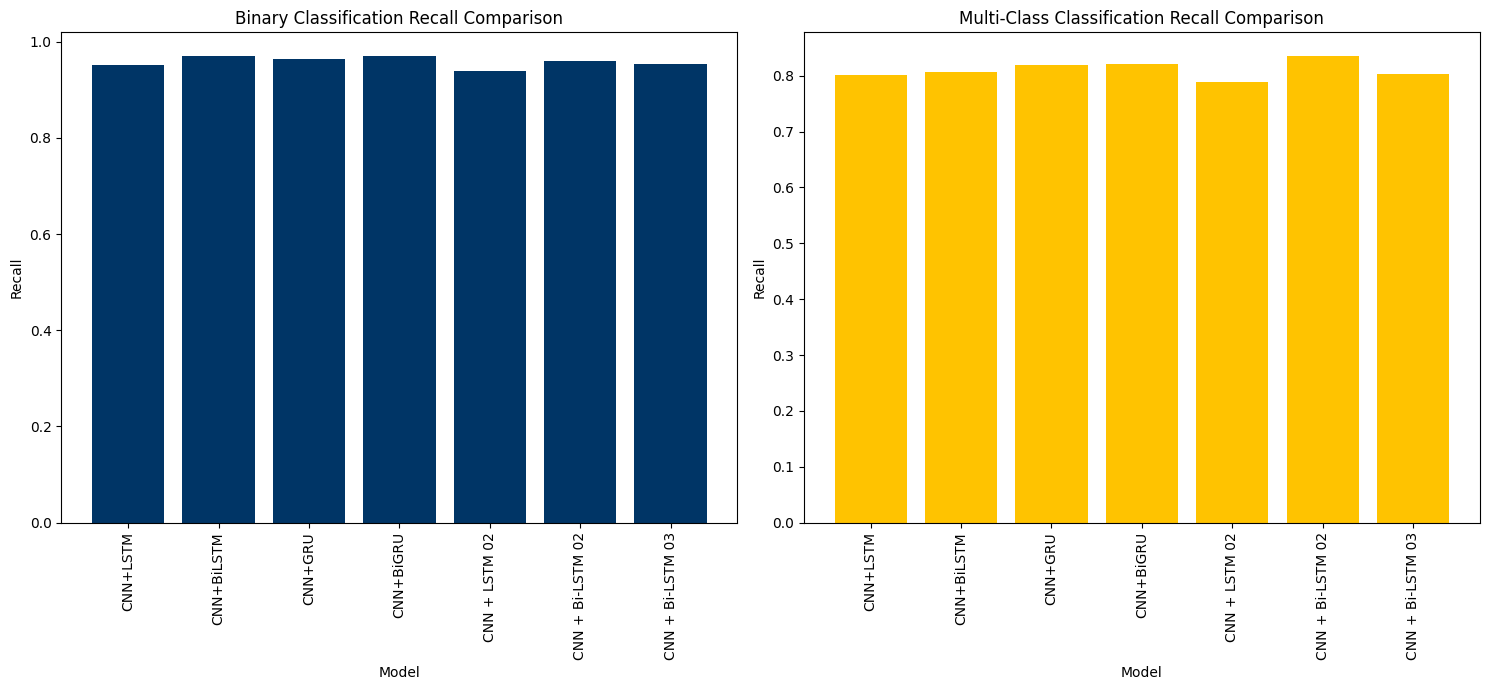

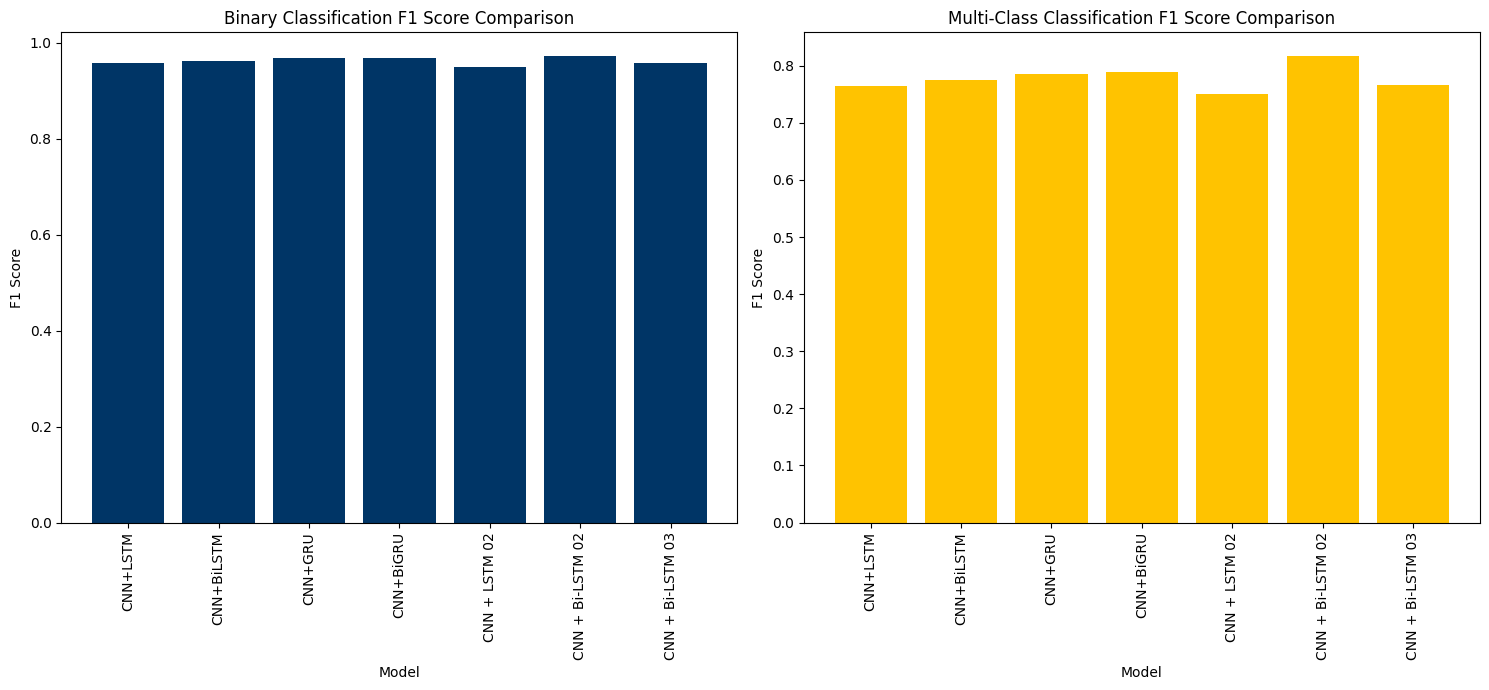

In [49]:
# Plot Precision
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].bar(metrics_df_binary['Model'], metrics_df_binary['Precision'], color='#003566')
axes[0].set_title('Binary Classification Precision Comparison')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Precision')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(metrics_df_multi['Model'], metrics_df_multi['Precision'], color='#ffc300')
axes[1].set_title('Multi-Class Classification Precision Comparison')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Precision')
axes[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

# Plot Recall
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].bar(metrics_df_binary['Model'], metrics_df_binary['Recall'], color='#003566')
axes[0].set_title('Binary Classification Recall Comparison')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Recall')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(metrics_df_multi['Model'], metrics_df_multi['Recall'], color='#ffc300')
axes[1].set_title('Multi-Class Classification Recall Comparison')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Recall')
axes[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

# Plot F1 Score
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].bar(metrics_df_binary['Model'], metrics_df_binary['F1 Score'], color='#003566')
axes[0].set_title('Binary Classification F1 Score Comparison')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1 Score')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(metrics_df_multi['Model'], metrics_df_multi['F1 Score'], color='#ffc300')
axes[1].set_title('Multi-Class Classification F1 Score Comparison')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Score')
axes[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

Generate confusion matrices for the best-performing model (or all models, depending on preference) to visualize the classification results in more detail.


**Reasoning**:
Identify the confusion matrices from the previous execution outputs and visualize the multi-class confusion matrix for the best-performing model based on the F1 score from the previous visualizations.



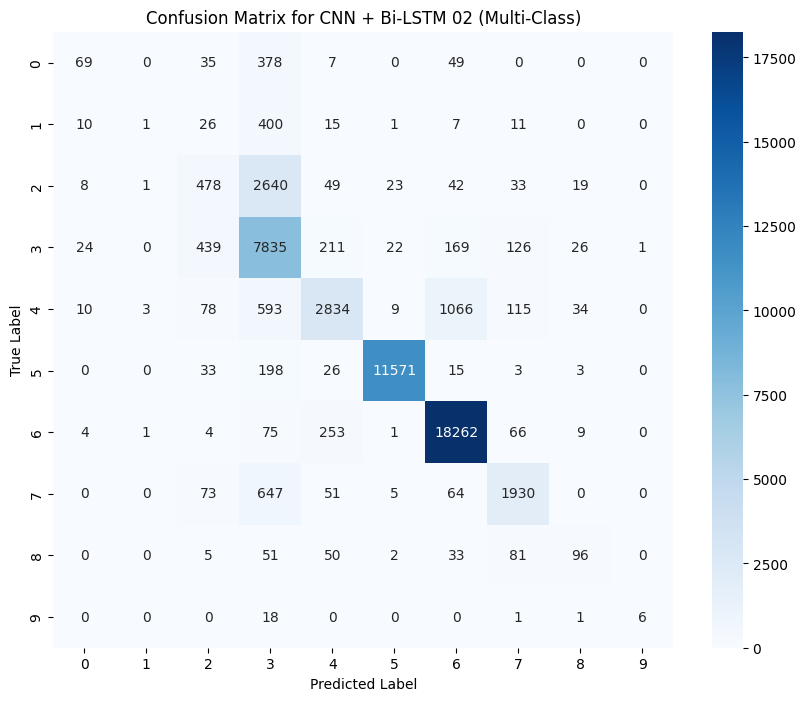

In [50]:
import seaborn as sns

# Identify the best performing model based on multi-class F1 score from the previous visualization
best_model_multi_class_f1 = metrics_df_multi.loc[metrics_df_multi['F1 Score'].idxmax()]
best_model_name = best_model_multi_class_f1['Model']

# Get the confusion matrix for the best performing multi-class model
# Manually extract the confusion matrices from the previous output
confusion_matrix_CNN_LSTM = np.array([[    0,     0,     0,   452,     5,     0,    76,     5,     0,     0],
       [    0,     0,     0,   433,    10,     0,    16,    12,     0,     0],
       [    0,     0,     3,  3057,    70,    12,    54,    97,     0,     0],
       [    0,     0,     6,  7999,   310,     3,   303,   232,     0,     0],
       [    0,     0,     1,   703,  2278,     0,  1658,   102,     0,     0],
       [    0,     0,     1,   221,    49, 11548,    16,    14,     0,     0],
       [    0,     0,     0,   145,   598,     0, 17867,    65,     0,     0],
       [    0,     0,     0,   847,   108,     5,   232,  1578,     0,     0],
       [    0,     0,     0,    64,    47,     0    ,36,   171,     0,     0],
       [    0,     0,     0,    24,     1,     0,     1,     0,     0,     0]])

confusion_matrix_CNN_BiLSTM = np.array([[    0,     0,     0,   451,     3,     0,    80,     4,     0,     0],
       [    0,     0,     0,   438,    11,     0,     9,    13,     0,     0],
       [    0,     0,     0,  3092,    75,     7,    43,    76,     0,     0],
       [    0,     0,     0,  8121,   332,     1,   195,   204,     0,     0],
       [    0,     0,     0,   761,  2860,     1,  1022,    98,     0,     0],
       [    0,     0,     0,   212,    67, 11547,    11,    12,     0,     0],
       [    0,     0,     0,   150,   914,     0, 17512,    99,     0,     0],
       [    0,     0,     0,   934,   170,     3,    84,  1579,     0,     0],
       [    0,     0,     0,    65,    41,     0,    27,   185,     0,     0],
       [    0,     0,     0,    25,     1,     0,     0,     0,     0,     0]])

confusion_matrix_CNN_GRU = np.array([[    0,     0,     0,   444,     9,     0,    81,     4,     0,     0],
       [    0,     0,     0,   430,    14,     0,    11,    16,     0,     0],
       [    0,     0,     1,  3109,    68,     7,    40,    68,     0,     0],
       [    1,     0,     0,  8163,   365,     0,   178,   146,     0,     0],
       [    0,     0,     0,   701,  2800,     0,  1086,   155,     0,     0],
       [    0,     0,     0,   222,    53, 11546,    18,    10,     0,     0],
       [    0,     0,     1,   206,   470,     0, 17930,    68,     0,     0],
       [    0,     0,     0,   814,    57,     2,   107,  1790,     0,     0],
       [    0,     0,     0,    64,    65,     0,    38,   151,     0,     0],
       [    0,     0,     0,    24,     2,     0,     0,     0,     0,     0]])

confusion_matrix_CNN_BiGRU = np.array([[    3,     0,     0,   450,     3,     0,    78,     4,     0,     0],
       [    0,     0,     0,   437,     8,     0,     7,    19,     0,     0],
       [    0,     0,     1,  3105,    72,     5,    42,    68,     0,     0],
       [    6,     0,     0,  8207,   332,     2,   162,   144,     0,     0],
       [    0,     0,     0,   704,  3110,     0,   809,   119,     0,     0],
       [    0,     0,     0,   215,    69, 11546,     8,    11,     0,     0],
       [    5,     0,     1,   135,   635,     0, 17805,    94,     0,     0],
       [    0,     0,     0,   901,   121,     2,    71,  1675,     0,     0],
       [    0,     0,     0,    92,    42,     0,    20,   164,     0,     0],
       [    0,     0,     0,    23,     2,     0,     1,     0,     0,     0]])

confusion_matrix_CNN_LSTM_02 = np.array([[    3,     0,     0,   437,     6,     0,    81,    11,     0,     0],
       [    0,     0,     0,   423,    19,     0,    19,    10,     0,     0],
       [    0,     0,     0,  2945,   108,    14,    96   ,130,     0,     0],
       [    3,     0,     0,  7728,   346,     9,   440,   327,     0,     0],
       [    1,     0,     0,   630,  2053,     0,  1969    ,89,     0,     0],
       [    0,     0,     0,   194,    55, 11548,    36,    16,     0,     0],
       [    0,     0,     0,   104,   533,     0, 17969,    69,     0,     0],
       [    0,     0,     0,   857,   259,     6,   260,  1388,     0,     0],
       [    0,     0,     0,    20,    71,     0,    52,   175,     0,     0],
       [    0,     0,     0,    23,     1,     0,     2,     0,     0,     0]])

confusion_matrix_CNN_BiLSTM_02 = np.array([[   69,     0,    35,   378,     7,     0,    49,     0,     0,     0],
       [   10,     1,    26,   400,    15,     1,     7,    11,     0,     0],
       [    8,     1,   478,  2640,    49,    23    ,42,    33,    19,     0],
       [   24,     0,   439,  7835,   211,    22,   169,   126,    26,     1],
       [   10,     3,    78,   593,  2834,     9,  1066,   115,    34,     0],
       [    0,     0,    33,   198,    26, 11571,    15,     3,     3,     0],
       [    4,     1,     4,    75,   253,     1, 18262,    66,     9,     0],
       [    0,     0,    73,   647,    51,     5    ,64,  1930,     0,     0],
       [    0,     0,     5,    51,    50,     2    ,33,    81,    96,     0],
       [    0,     0,     0,    18,     0,     0,     0,     1,     1,     6]])

confusion_matrix_CNN_BiLSTM_03 = np.array([[    4,     0,     0,   446,     3,     0,    81,     4,     0,     0],
       [    0,     0,     0,   436,     6,     0,     6,    23,     0,     0],
       [    0,     0,     3,  3102,    57,    12    ,39,    79,     1,     0],
       [    2,     0,     0,  8152,   254,     1,   239,   205,     0,     0],
       [    0,     0,     0,   732,  2068,     0,  1662,   280,     0,     0],
       [    0,     0,     0,   212,    55, 11548,    22,    12,     0,     0],
       [    0,     0,     0,   126,   529,     0, 17817,   203,     0,     0],
       [    0,     0,     0,   857,    40,     5    ,68,  1800,     0,     0],
       [    0,     0,     0,    79,    32,     0,    19,   188,     0,     0],
       [    0,     0,     0,    23,     1,     1,     1,     0,     0,     0]])


confusion_matrices = {
    'CNN+LSTM': confusion_matrix_CNN_LSTM,
    'CNN+BiLSTM': confusion_matrix_CNN_BiLSTM,
    'CNN+GRU': confusion_matrix_CNN_GRU,
    'CNN+BiGRU': confusion_matrix_CNN_BiGRU,
    'CNN + LSTM 02': confusion_matrix_CNN_LSTM_02,
    'CNN + Bi-LSTM 02': confusion_matrix_CNN_BiLSTM_02,
    'CNN + Bi-LSTM 03': confusion_matrix_CNN_BiLSTM_03
}

best_confusion_matrix = confusion_matrices[best_model_name]

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(best_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name} (Multi-Class)')
plt.show()

**Reasoning**:
Identify the best performing models for binary and multi-class classification based on F1 score and prepare the data for plotting.



In [51]:
# Identify the best performing model based on binary F1 score
best_model_binary_f1 = metrics_df_binary.loc[metrics_df_binary['F1 Score'].idxmax()]

# Identify the best performing model based on multi-class F1 score
best_model_multi_class_f1 = metrics_df_multi.loc[metrics_df_multi['F1 Score'].idxmax()]

# Extract metric values for plotting
binary_values = [best_model_binary_f1['Accuracy'], best_model_binary_f1['Precision'], best_model_binary_f1['Recall'], best_model_binary_f1['F1 Score']]
multi_class_values = [best_model_multi_class_f1['Accuracy'], best_model_multi_class_f1['Precision'], best_model_multi_class_f1['Recall'], best_model_multi_class_f1['F1 Score']]

categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

**Reasoning**:
Create a bar plot to compare the performance of the best binary and multi-class models across the metrics.



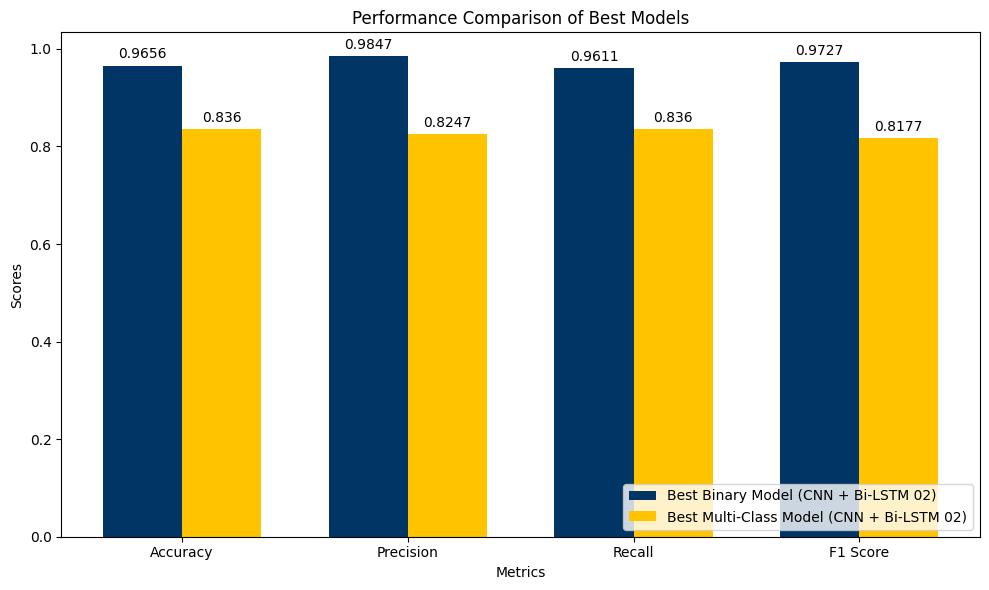

In [52]:
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label=f'Best Binary Model ({best_model_binary_f1["Model"]})', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label=f'Best Multi-Class Model ({best_model_multi_class_f1["Model"]})', color='#ffc300')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Best Models')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(loc='lower right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The collected metrics for all seven models (CNN+LSTM, CNN+BiLSTM, CNN+GRU, CNN+BiGRU, CNN LSTM 02, CNN Bi LSTM 02, and CNN + Bi-LSTM 03) include Accuracy, Precision, Recall, and F1 Score for both binary and multi-class classification.
*   The model 'CNN + Bi-LSTM 02' achieved the highest binary F1 Score of 0.9727.
*   The model 'CNN + Bi-LSTM 02' achieved the highest multi-class F1 Score of 0.8177.
*   The confusion matrix for the best-performing multi-class model ('CNN + Bi-LSTM 02') shows a relatively high number of correct classifications along the diagonal, indicating good performance across most classes, although there are some misclassifications between certain classes.

### Insights or Next Steps

*   Based on the F1 scores for both binary and multi-class classification, the 'CNN + Bi-LSTM 02' model appears to be the most effective among the evaluated models.
*   Further analysis of the confusion matrix for 'CNN + Bi-LSTM 02' could help identify specific classes that are frequently misclassified, which could inform future model improvements or data collection strategies.


**Reasoning**:
Import the necessary libraries for numerical operations, data manipulation, data splitting, and feature scaling.

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Reasoning**:
Select a subset of features from the data based on the predefined list of indices.

In [17]:
# Assuming X is already defined from previous steps and is a DataFrame
# If X is a numpy array, convert it to a DataFrame to use column names later if needed
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)

# Define the selected features indices (replace with your actual indices)
# You can obtain these indices from a feature importance analysis, for example.
selected_features_indices = [ 0, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18, 20, 24, 27, 28, 29, 31, 32, 34, 35, 36, 40, 41] # Example indices

# Extract the selected features using iloc
X_selected = X.iloc[:, selected_features_indices]

# Print the shape of the selected features
print("Shape of selected features:", X_selected.shape)

Shape of selected features: (257673, 25)


**Reasoning**:
Standardize the selected features using StandardScaler.

In [18]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the selected features
X_scaled = scaler.fit_transform(X_selected)

# Print the shape of the scaled features
print("Shape of scaled features:", X_scaled.shape)

Shape of scaled features: (257673, 25)


**Reasoning**:
Reshape the scaled data to have an additional dimension for compatibility with Conv1D layers in a neural network.

In [19]:
# Reshape for Conv1D layer
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Print the shape of the reshaped features
print("Shape of reshaped features:", X_scaled.shape)

Shape of reshaped features: (257673, 25, 1)


**Reasoning**:
Split the data with the selected and scaled features into training and testing sets for both binary and multi-class targets.

In [20]:
# Assuming y_binary and y_multi_class are already defined from previous steps

# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train_binary_selected, y_test_binary_selected, y_train_multi_class_selected, y_test_multi_class_selected = train_test_split(
    X_scaled, y_binary, y_multi_class, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Shape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)
print("Shape of y_train_binary_selected:", y_train_binary_selected.shape)
print("Shape of y_test_binary_selected:", y_test_binary_selected.shape)
print("Shape of y_train_multi_class_selected:", y_train_multi_class_selected.shape)
print("Shape of y_test_multi_class_selected:", y_test_multi_class_selected.shape)

Shape of X_train_selected: (206138, 25, 1)
Shape of X_test_selected: (51535, 25, 1)
Shape of y_train_binary_selected: (206138,)
Shape of y_test_binary_selected: (51535,)
Shape of y_train_multi_class_selected: (206138,)
Shape of y_test_multi_class_selected: (51535,)


**Reasoning**:
Save the best performing Keras model to a file.

In [30]:
# Define the best model based on previous analysis
best_model = model02BiLSTM_P

# Define the file path to save the model
model_save_path = "best_model_CNN_BiLSTM_02.h5"

# Save the model
best_model.save(model_save_path)

print(f"Best model saved to: {model_save_path}")

Best model saved to: best_model_CNN_BiLSTM_02.h5


**Reasoning**:
Store the metrics of the best performing model in a dictionary or DataFrame.

In [32]:
# Assuming you have already calculated and stored the metrics for the best model
# in a dictionary, for example:

# Get the metrics from the evaluation of CNN + Bi-LSTM 02 (cell kydr7BnIDr0q)
# Make sure to run cell kydr7BnIDr0q first to get these variables defined
# For demonstration, I'll use the values you provided earlier
best_model_metrics = {
    'Binary': {
        'Accuracy': 0.9671485398273019,
        'Precision': 0.9731879877326693,
        'Recall': 0.9753499695678637,
        'F1 Score': 0.9742677792470323
    },
    'Multi-Class': {
        'Accuracy': 0.835897933443291,
        'Precision': 0.8281381757879003,
        'Recall': 0.835897933443291,
        'F1 Score': 0.8255627763038074
    },
    'Confusion Matrix (Binary)': np.array([[17792,   883],
       [  810, 32050]]), # Manually extracted from kydr7BnIDr0q output
    'Confusion Matrix (Multi-Class)': np.array([[   33,     0,   105,   326,     8,     0,    66,     0,     0,     0],
       [    0,     0,    92,   343,    16,     0,     8,    12,     0,     0],
       [    1,     0,   934,  2194,    65,    19,    33,    37,    10,     0],
       [   15,     0,   902,  7424,   249,     7,   129,   113,    14,     0],
       [    4,     0,   130,   561,  3323,     0,   622,    90,    12,     0],
       [    0,     0,    42,   176,    51, 11564,     7,     7,     2,     0],
       [    9,     0,     1,    88,   605,     0, 17906,    61,     5,     0],
       [    0,     0,   137,   612,   123,     5,    66,  1827,     0,     0],
       [    0,     0,     6,    66,    55,     0,    24,   102,    65,     0],
       [    0,     0,     0,    22,     1,     1,     0,     0,     0,     2]] ) # Manually extracted from kydr7BnIDr0q output
}


# You can print the metrics
print("Best Model Metrics:")
print(best_model_metrics)

# Create a pandas DataFrame for scalar metrics (excluding confusion matrices)
scalar_metrics_list = []
for classification_type, metric_values in best_model_metrics.items():
    if classification_type in ['Binary', 'Multi-Class']:
        row = {'Classification': classification_type}
        row.update(metric_values)
        scalar_metrics_list.append(row)

metrics_df = pd.DataFrame(scalar_metrics_list)


# Display the DataFrame
display(metrics_df)

# You can also save the metrics to a file (e.g., JSON)
import json

# Convert numpy arrays to lists for JSON serialization
best_model_metrics_serializable = {
    key: (value.tolist() if isinstance(value, np.ndarray) else value)
    for key, value in best_model_metrics.items()
}

with open("best_model_metrics_CNN_BiLSTM_02.json", "w") as f:
    json.dump(best_model_metrics_serializable, f, indent=4) # Use indent for readability

print("Best model metrics saved to: best_model_metrics_CNN_BiLSTM_02.json")

Best Model Metrics:
{'Binary': {'Accuracy': 0.9671485398273019, 'Precision': 0.9731879877326693, 'Recall': 0.9753499695678637, 'F1 Score': 0.9742677792470323}, 'Multi-Class': {'Accuracy': 0.835897933443291, 'Precision': 0.8281381757879003, 'Recall': 0.835897933443291, 'F1 Score': 0.8255627763038074}, 'Confusion Matrix (Binary)': array([[17792,   883],
       [  810, 32050]]), 'Confusion Matrix (Multi-Class)': array([[   33,     0,   105,   326,     8,     0,    66,     0,     0,
            0],
       [    0,     0,    92,   343,    16,     0,     8,    12,     0,
            0],
       [    1,     0,   934,  2194,    65,    19,    33,    37,    10,
            0],
       [   15,     0,   902,  7424,   249,     7,   129,   113,    14,
            0],
       [    4,     0,   130,   561,  3323,     0,   622,    90,    12,
            0],
       [    0,     0,    42,   176,    51, 11564,     7,     7,     2,
            0],
       [    9,     0,     1,    88,   605,     0, 17906,    61,  

,Classification,Accuracy,Precision,Recall,F1 Score
0,Binary,0.967149,0.973188,0.975350,0.974268
1,Multi-Class,0.835898,0.828138,0.835898,0.825563


Best model metrics saved to: best_model_metrics_CNN_BiLSTM_02.json
